This is a notebook following the "Deep learning Workshop for Satellite Imagery - Data Processing" tutorial found on YouTube by Dr. Avkash Chauhan. Please see their Github page (https://github.com/prodramp/DeepWorks/tree/main/DL-SatelliteImagery) for the tutorial, code, and info.

It uses Dubai dataset with Segmentation images, downloaded from Kaggle (https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery). Humans in the Loop are the owners of the data (https://humansintheloop.org/resources/datasets/semantic-segmentation-dataset-2/)

In [134]:
#Required libraries; make a requirements.txt file at some point
# %pip install opencv-python
# %pip install patchify
# %pip install cv2
# %pip install scikit-learn
# %pip install tensorflow
#%pip install -U segmentation_models 
#%pip install pydot
#%pip install graphviz

     ---------------------------------------- 47.0/47.0 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [135]:
import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from keras.models import Model 
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

from keras import backend as K  #Backend will be tensorflow, but you can tell it to use a different deep learning library if you want
from keras.utils import plot_model
import pydot

import graphviz





In [3]:
import keras

In [4]:
minmaxscaler = MinMaxScaler() #This needs to be at the top for some reason. I am not sure why, to be honest. It initially worked if you called it right before you used it?

In [5]:
#Set the root directory for this project
dataset_root_folder = "C:/Users/Chance/Documents/RemoteSensing/MBRSC_Dubai_samples" #Change to your working directory. Relative path did not work with cv2 for some reason.

#Name your dataset
dataset_name = "SemanticSegmentationDataset"


OSwalk helps us select a folder and returns the paths of subdirectories and files. Use the next code chucnk to specify the type of image to confirm what you're using (i.e. images or masks)


In [6]:
for path, subdirs, files in os.walk(dataset_root_folder):
    dir_name = path.split(os.path.sep)[-1]
    print(dir_name)
    if dir_name == 'images':
        images = os.listdir(path)
        #print(images)
        for i, image_name in enumerate(images):
            print(image_name)
        

C:/Users/Chance/Documents/RemoteSensing/MBRSC_Dubai_samples
SemanticSegmentationDataset
Tile 1
images
image_part_001.jpg
image_part_002.jpg
image_part_003.jpg
image_part_004.jpg
image_part_005.jpg
image_part_006.jpg
image_part_007.jpg
image_part_008.jpg
image_part_009.jpg
masks
Tile 2
images
image_part_001.jpg
image_part_002.jpg
image_part_003.jpg
image_part_004.jpg
image_part_005.jpg
image_part_006.jpg
image_part_007.jpg
image_part_008.jpg
image_part_009.jpg
masks
Tile 3
images
image_part_001.jpg
image_part_002.jpg
image_part_003.jpg
image_part_004.jpg
image_part_005.jpg
image_part_006.jpg
image_part_007.jpg
image_part_008.jpg
image_part_009.jpg
masks
Tile 4
images
image_part_001.jpg
image_part_002.jpg
image_part_003.jpg
image_part_004.jpg
image_part_005.jpg
image_part_006.jpg
image_part_007.jpg
image_part_008.jpg
image_part_009.jpg
masks
Tile 5
images
image_part_001.jpg
image_part_002.jpg
image_part_003.jpg
image_part_004.jpg
image_part_005.jpg
image_part_006.jpg
image_part_007.jpg
i

Next, can use OpenCV to read the data in the image. 

In [7]:
#Use cv2 in opencv to read the data in the image
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 1/images/image_part_001.jpg',1)
image
# image.shape #get height, width, and color type (e.g. RGB, greyscale)

array([[[201, 195, 190],
        [225, 219, 214],
        [241, 232, 228],
        ...,
        [255, 236, 231],
        [254, 234, 229],
        [255, 239, 234]],

       [[226, 220, 215],
        [254, 248, 243],
        [255, 255, 251],
        ...,
        [252, 231, 229],
        [247, 228, 223],
        [242, 223, 218]],

       [[248, 241, 238],
        [255, 252, 249],
        [255, 255, 251],
        ...,
        [253, 234, 231],
        [252, 235, 232],
        [245, 228, 225]],

       ...,

       [[211, 200, 203],
        [220, 209, 212],
        [221, 211, 217],
        ...,
        [220, 229, 242],
        [234, 243, 255],
        [235, 244, 255]],

       [[209, 198, 201],
        [219, 208, 211],
        [220, 210, 216],
        ...,
        [213, 222, 235],
        [222, 231, 244],
        [218, 227, 240]],

       [[213, 202, 205],
        [210, 199, 202],
        [201, 191, 197],
        ...,
        [223, 232, 245],
        [233, 242, 255],
        [230, 239, 252]]

Next, you can get the image type once it's read in.

In [8]:
print(type(image))


<class 'numpy.ndarray'>


We need to convert the image type from numpy.ndarray to the correct image type.

In [9]:
type(Image.fromarray(image))

PIL.Image.Image

However, not all our images are in the same shape (they have different dimensions, seen below). Currently, each tile has different dimensions. We need to make sure everything is the same shape before we can begin.

In [10]:
image_dataset = [] #create an array since the imageset is divided into diff tiles. Iterate and create tile_id for each tile to make this easier
image_extension = 'jpg' #since we want the jpg images right now
for tile_id in range(1,8):
    for image_id in range(1,20):
        image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/images/image_part_00{image_id}.{image_extension}', 1)  #imread returns RGB order, but ours is in BGR data. Remember this
        if image is not None:
            print(image.shape)

(644, 797, 3)
(644, 797, 3)
(644, 797, 3)
(643, 797, 3)
(643, 797, 3)
(643, 797, 3)
(644, 797, 3)
(644, 797, 3)
(644, 797, 3)
(544, 509, 3)
(544, 510, 3)
(544, 509, 3)
(544, 509, 3)
(544, 510, 3)
(544, 509, 3)
(544, 509, 3)
(544, 510, 3)
(544, 509, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)


(658, 682, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(2061, 1817, 3)
(2061, 1816, 3)
(2061, 1817, 3)
(2062, 1817, 3)
(2062, 1816, 3)
(2062, 1817, 3)
(2061, 1817, 3)
(2061, 1816, 3)
(2061, 1817, 3)


### Tile and Mask processing
1. Decide the patch size for our images (i.e. 256x256 or 512x512)
2. Make sure all the tiles and mask images size are multiples of the patch size
3. Split all the images into the patch size and convert it into numpy array

In [11]:
#Define image patch size
image_patch_size = 256

#Get image shape again, use Tile 2 this time.
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg',1)
image.shape
#If image size is 544x509, this doesn't match up with the 256, so we need to mod it with our patch size
(image.shape[0]//image_patch_size)*image_patch_size

512

In [12]:
### Issue with MinMaxScaler here. Idk why it won't work here (it did on the initial runtrhough of the tutorial, but doesn't now), but works fine later.

#Here is an example of how to convert every pixel to a value between 0 and 1 using the MinMaxScaler library

#image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step = image_patch_size)
#image_patches
#
#
#image_x = image_patches[0,0,:,:]
#image_y = minmaxscaler.fit_transfrom(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)

In [13]:
image_dataset = [] #create an array since the imageset is divided into diff tiles. Iterate and create tile_id for each tile to make this easier\
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #This line makes sure you're converting the BGR color to RGB, which we need.
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))

        #To apply patch, need to convert image back to np arry
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

image_dataset = np.array(image_dataset) #convert the datasets in numpy arrays
mask_dataset = np.array(mask_dataset)


In [14]:
#Check length of datasets to confirm they match, then check to make sure they're in arrays that match
print(len(image_dataset))
print(len(mask_dataset))
image_dataset
mask_dataset

945
945


array([[[[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        ...,

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
        

Output is decimal values because we used the MinMaxScaler to convert to values between 0 and 1

Let's display the first image from the image_dataset

numpy.ndarray

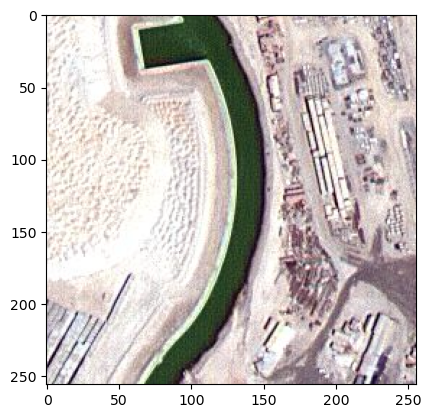

In [15]:
plt.imshow(image_dataset[0])
type(image_dataset[0]) #confirming it is a numpy array


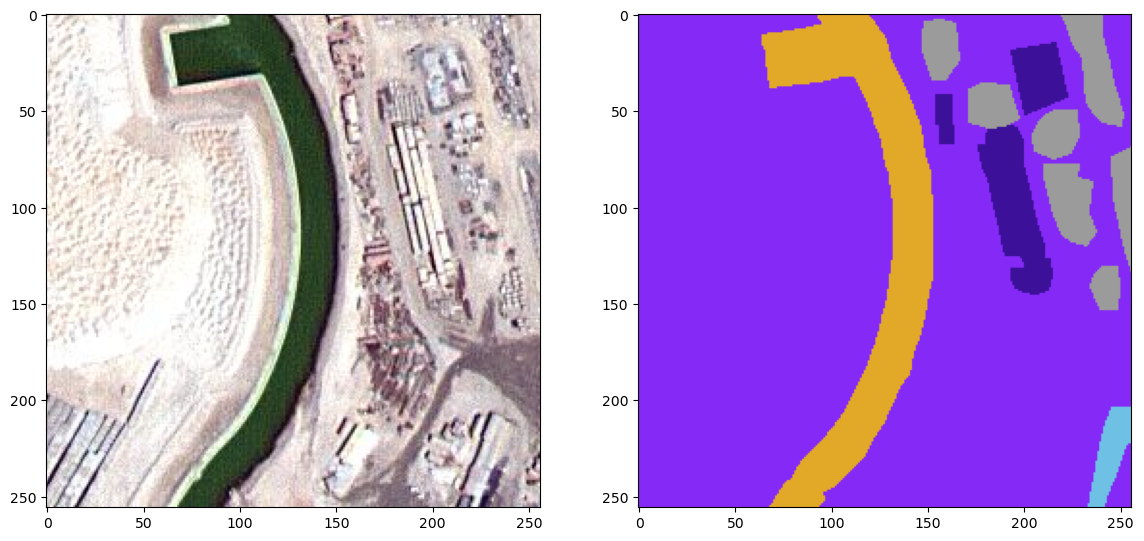

In [16]:
#Let's show the image and mask side by side to compare.
plt.figure(figsize = (14,8))
plt.subplot(121) #Needs to be 3 numbers to specify nrows, ncols, and index
plt.imshow(image_dataset[0])
plt.subplot(122)
plt.imshow(mask_dataset[0])

You can even check random images and masks by assigning an image id to each image or mask in the dataset and call that instead of specifying the index. The following code will return the image and mask of a random image each time you run it.

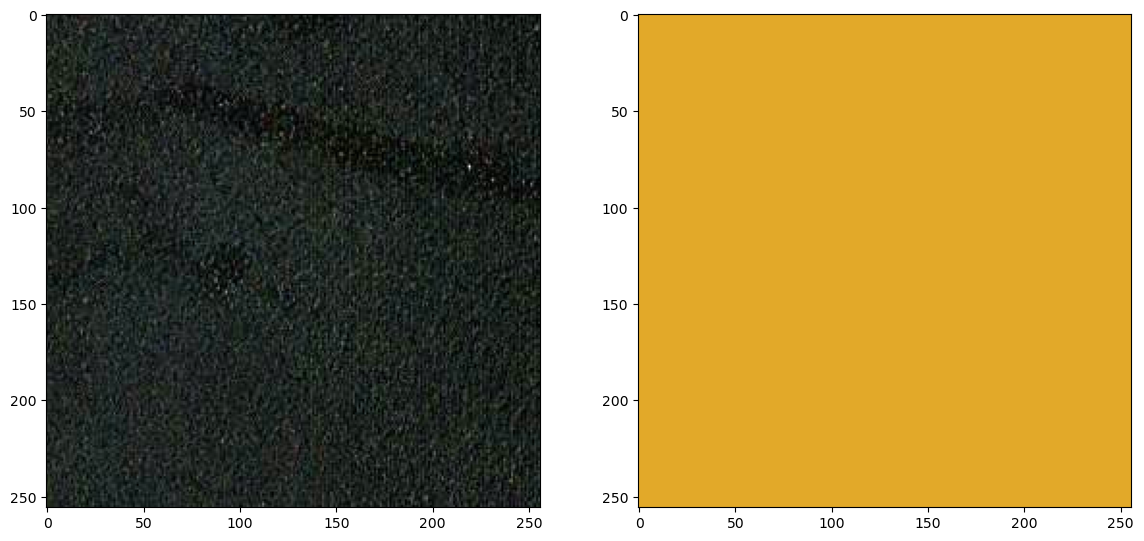

In [17]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize = (14,8))
plt.subplot(121) 
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

### Processing Mask Labels

Looking at the json files or data card on Kaggle, we can find the labels for the masks, including buildings, land, road, vegetation, water, and unlabeled areas.

In [18]:
class_building = '#3c1098' #Get the value from the data card. Store as string. Remove the hash sign, though, using the next function
class_building = class_building.lstrip('#')

#We also need to split the initial value into 3 segments (e.g. 3c1098 into 3C 10 98). Generate a tuple. 16 is the base for hexadecimal
tuple(int(class_building[i:i+2], 16) for i in (0,2,4))

#Now convert to np array
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))


In [19]:
#repeat the process for the other classes
class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))


Now we need to take the RGB value and conver to a 2D label

In [20]:
mask_dataset.shape

(945, 256, 256, 3)

In [21]:
#We want to do this to our individual patched masks
#label = individual_patched_mask
#
#def rgb_to_label(label):
#    label_segment = np.zeros(label.shape, dtype = np.uint8) #creating empty array same size as the labels dataset so we can fill it
#    print(label_segment.shape)
#    label_segment = 1
#    return label_segment

In [22]:
#So there's 945 images in shape 256, 256, 3
#labels = []
#for i in range(mask_dataset.shape[0]):
#    label = rgb_to_label(mask_dataset[i])
#    labels.append(label)


In [23]:
##check length to confirm
#len(labels)
#
##turn into numpy array
#labels = np.array(labels)
#
#labels[0]

##### Now let's take a look at the label coding. 

Looking at the info in classes.json file, we see that water = 0, land = 1, road = 2, building = 3, vegetation = 4, and unlabeled = 5. 

In [24]:
#We want to do this to our individual patched masks
label = individual_patched_mask


def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)  #creating empty array same size as the labels dataset so we can fill it
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0] #Take only one value, so use the :,:,0 notation
  print(label_segment)
  return label_segment
     






In [25]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)
     

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 5 5 ... 0 0 0]
 [1 5 5 ... 0 0 0]
 [1 1 5 ... 0 0 0]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [

In [26]:
labels = np.array(labels)



In [27]:
labels[3]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [28]:
labels = np.expand_dims(labels, axis = 3)

In [29]:
labels[0]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

In [30]:
np.unique(labels)

print("Total unique labels based on masks:", format(np.unique(labels)))

Total unique labels based on masks: [0 1 2 3 4 5]


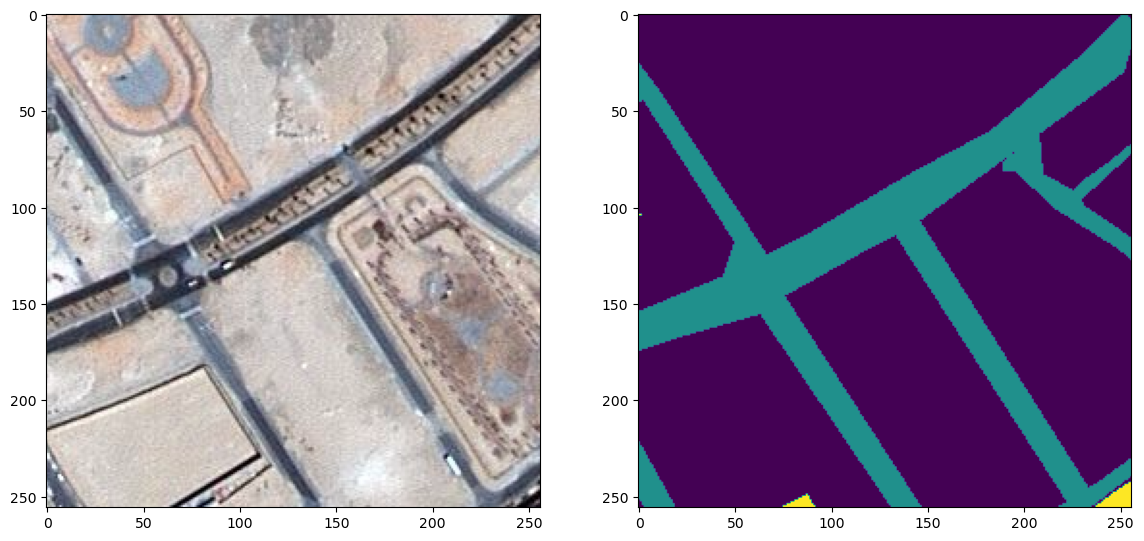

In [31]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize = (14,8))
plt.subplot(121) 
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [32]:
labels[0][:,:,0] #This slices the data, shows you what values are in that firat mask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

### Creating Training and Test Dataset

In [33]:
total_classes = len(np.unique(labels)) #How many unique classes we have (we know this though, this just confirms we've still got them)
total_classes

6

In [34]:
# from tensorflow import keras

# from tensorflow.keras.utils import to_categorical

In [35]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes, ) #process labels dataset as y, need to provide the total # of classes, and can provide the data type if you need to.

In [36]:
labels_categorical_dataset

array([[[[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        ...,

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0.

In [37]:
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [38]:
master_training_dataset = image_dataset


In [39]:
master_training_dataset.shape

(945, 256, 256, 3)

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
x_train, x_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size= 0.15, random_state=100) #needs input dataset and corresponding labels dataset, and dataset shapes must match.

In [42]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [43]:
image_height = x_train.shape[1] #Just checking things to make sure they still match up with what we wanted. Can do the same for the Y, too.
image_width = x_train.shape[2]
image_channels = x_train.shape[3]

print(image_height)
print(image_width)
print(image_channels)

256
256
3


### Now we move on to training and prediction (Part 2 of 3 in the workshop videos)

In [44]:
# from keras.models import Model 
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
# from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [45]:
# from keras import backend as K  #Backend will be tensorflow, but you can tell it to use a different deep learning library if you want

Evaluation Metrics: Jaccard Index / Intersection over Union (IOU). It's the overlap divided by the union of the data. Basically dividing what the two datasets (training and test) have in common over the entire master dataset. This is called the Jaccard Index. We will apply this to our labels data.

If the overlap in your data is the exact same as the union in the dataset, your IOU will be = 1. If the overlap is not a perfect match, you'll get a much lower value. Getting over 90% overlap is a great result.

In [46]:
#Calculate jaccard coefficient
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

     


We'll be using the U-net: Convolutional Networks for Biomedical Image Segmentation model from here https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ where you can find the model architecture. We will also be using Netron app to visualize (any) deep learning model: https://netron.app

The image below is the U-net model architecture.

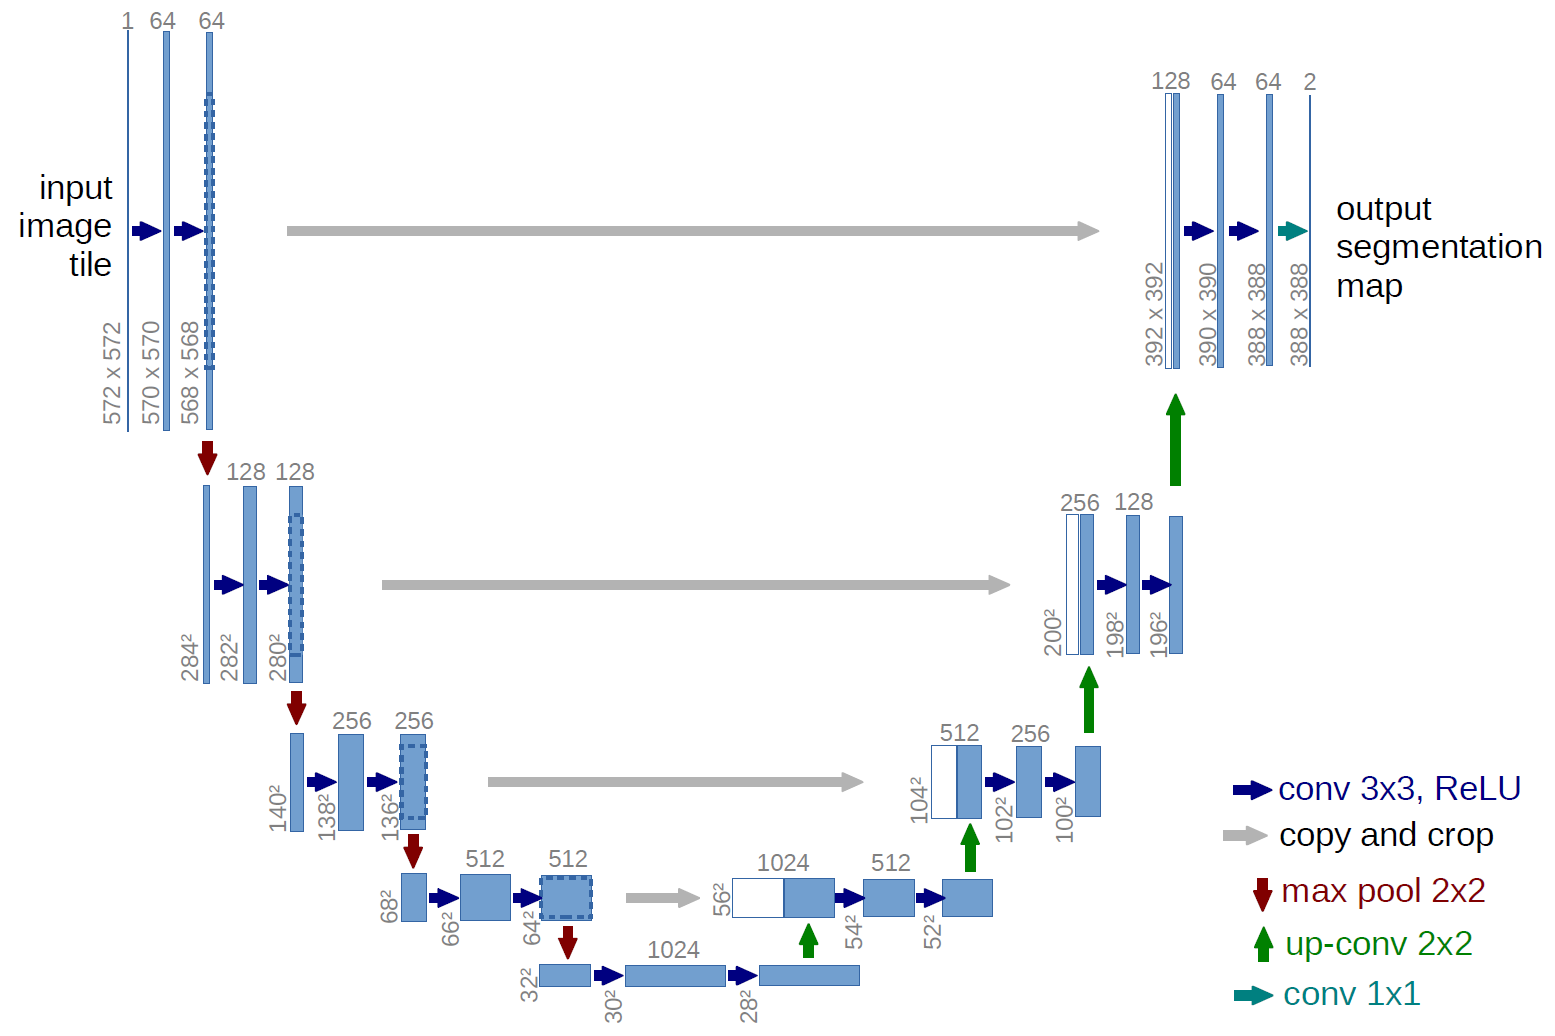

In [47]:
from IPython.display import Image
Image(filename="C:/Users/Chance/Documents/RemoteSensing/Unet_architecture.png")

Creation of the U-net model

In [48]:
def multi_unet_model(n_classes = 5, image_height = 256, image_width = 256, image_channels = 1):   #default values

    inputs = Input((image_height, image_width, image_channels))

    source_input = inputs
    
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input) #first convolutional 2d layer. See the architecture diagram on U-net website linked above to see that the convolution is 3x3 and activation is ReLU
    c1 = Dropout(0.2)(c1) #as a rate, so this drops 20% of the values. So we created a convolutional layer, passed the input (c1), then take the 20% dropout off, then the remainder is the new c1 with 80% of original points left. You can experiment with different values and see how it affects your model
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1) # you need to do 2 convolution layers according to the model arch, so do the exact same convolution as the first time. 
    p1 = MaxPooling2D((2,2))(c1) #again, you may need to adjust and validate the 2,2 values based on your dataset

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1) #32 for 2nd convolution layer instead of 16 because we need to double it for max pooling step
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2) #64 because you double it again. Check the arch diagram to see when you double
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3) 
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4) 
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)
    #No max pooling this time! Only 4x

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding= "same")(c5) #moving on to up-conversion or up-sampling  
    u6 = concatenate([u6, c4]) #copy and crop step
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding= "same")(c6)    
    u7 = concatenate([u7, c3]) #moving back up now, so c4 to c3
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding= "same")(c7)    
    u8 = concatenate([u8, c2]) 
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding= "same")(c8)    
    u9 = concatenate([u9, c1], axis = 3) #the default axis is -1, but since we don't need any further concatenation, we'll perform concat on the axis 3
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    #output layer is the final convolution
    outputs = Conv2D(n_classes, (1,1), activation = "softmax")(c9)
  

    model = Model(inputs =[inputs],outputs =[outputs])
    return model

In [49]:
metrics = ["accuracy", jaccard_coef]

In [50]:
def get_deep_learning_model():
    return multi_unet_model(n_classes = total_classes, 
                            image_height = image_height, 
                            image_width = image_width, 
                            image_channels = image_channels)

In [51]:
model = get_deep_learning_model() #if you get an error, go back and reduce the number of layers by commenting out many of the later layers and creating a temporary output layer with the new, reduced layer (c3 or whatever) instead of c9 or whatevr your last layer ends up being


### Custom Loss Function creation

We will be using the focal loss (extension of Cross entropy loss).

Need to equally weight classes for the Dice loss. Use the Dice Loss, together with Focal Loss, to calculate Total Loss. The classes need to be weighted equally so there's no bias in class prediction just because the training dataset had more or less of a given class.

Total loss = Dice Loss + (1 * Focal Loss)

In [52]:
weights = [0.166, 0.166, 0.166, 0.166, 0.166, 0.166] #1/6 = 1.66 repeating

In [53]:
#I do not know why this has to be here. But "import segmentation_models as sm does not work otherwise.""
os.environ["SM_FRAMEWORK"] = "tf.keras"

# from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [54]:
#Pass the weights
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [55]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [56]:
total_loss = dice_loss + (1*focal_loss)

### Model Compilation

In [57]:
tf.keras.backend.clear_session()

In [58]:
model.compile(optimizer="adam", loss = total_loss, metrics = metrics)

In [59]:
model.summary() #generate model summary to make sure it worked

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

### Small-scale Model Training

In [60]:
# model_history = model.fit(x_train, y_train,
#                           batch_size = 16,
#                           verbose = 1,
#                           epochs = 10,
#                           validation_data = (x_test, y_test),
#                           shuffle = False)

In [61]:
# history_a = model_history

NameError: name 'model_history' is not defined

C:\Users\Chance\AppData\Local\Temp\ipykernel_3268\2289579422.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label = "training loss", color = "blue")
C:\Users\Chance\AppData\Local\Temp\ipykernel_3268\2289579422.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'y', label = "validation loss", color = "green")


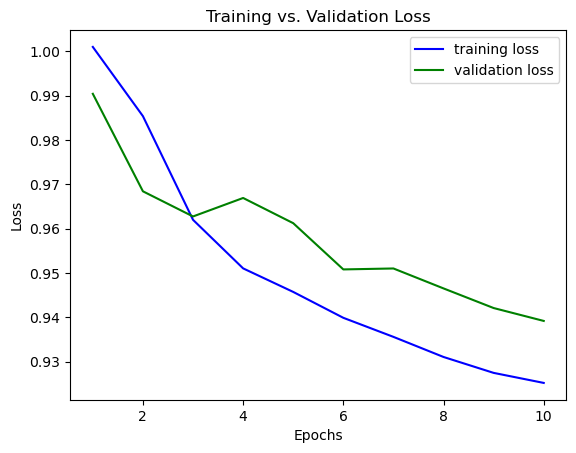

In [ ]:
# history_a.history #Gives us the results for each epoch

# loss = history_a.history['loss'] #Create an array saving the loss values from the model

# val_loss = history_a.history['val_loss'] #validation loss

# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label = "training loss", color = "blue")
# plt.plot(epochs, val_loss, 'y', label = "validation loss", color = "green")
# plt.title("Training vs. Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()


We want to go from high (1) to low (0) in loss

C:\Users\Chance\AppData\Local\Temp\ipykernel_3268\2848862570.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, jaccard_coef, 'y', label = "Training IoU", color = "blue")
C:\Users\Chance\AppData\Local\Temp\ipykernel_3268\2848862570.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_jaccard_coef, 'y', label = "Validation IoU", color = "green")


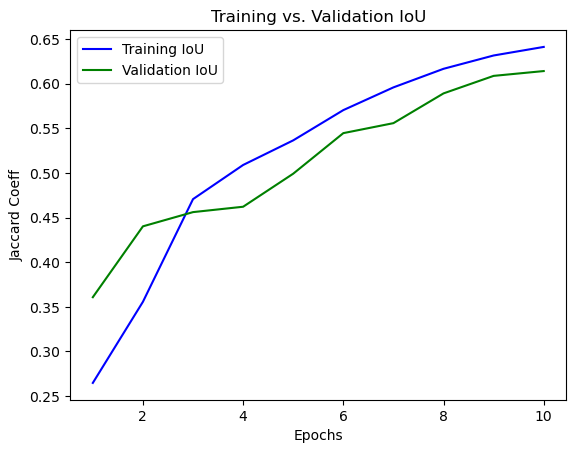

In [ ]:
# #Get the Jaccard Coeff values and plot
# jaccard_coef = history_a.history['jaccard_coef'] #Create an array saving the loss values from the model

# val_jaccard_coef = history_a.history['val_jaccard_coef'] #validation loss

# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, jaccard_coef, 'y', label = "Training IoU", color = "blue")
# plt.plot(epochs, val_jaccard_coef, 'y', label = "Validation IoU", color = "green")
# plt.title("Training vs. Validation IoU")
# plt.xlabel("Epochs")
# plt.ylabel("Jaccard Coeff")
# plt.legend()
# plt.show()

Remember, the goal is to reach IoU = 1 since that represents a complete overlap in the training and test sets

### Large-scale Model training

Set epochs from 10 to 100. Since we aren't utilizing GPUs to help us, this will take much longer. 10 epochs took over 27 minutes on Prometheus (Desktop) and took twice as long on Thoth (Surface Laptop 2)

In [62]:
model_history = model.fit(x_train, y_train,
                          batch_size = 16,
                          verbose = 1,
                          epochs = 100,
                          validation_data = (x_test, y_test),
                          shuffle = False)

Epoch 1/100
51/51 [==============================] - 168s 3s/step - loss: 0.9952 - accuracy: 0.5994 - jaccard_coef: 0.2970 - val_loss: 0.9871 - val_accuracy: 0.6597 - val_jaccard_coef: 0.3344
Epoch 2/100
51/51 [==============================] - 165s 3s/step - loss: 0.9717 - accuracy: 0.6990 - jaccard_coef: 0.4106 - val_loss: 0.9662 - val_accuracy: 0.6942 - val_jaccard_coef: 0.4681
Epoch 3/100
51/51 [==============================] - 169s 3s/step - loss: 0.9588 - accuracy: 0.7337 - jaccard_coef: 0.4842 - val_loss: 0.9715 - val_accuracy: 0.6945 - val_jaccard_coef: 0.4852
Epoch 4/100
51/51 [==============================] - 165s 3s/step - loss: 0.9535 - accuracy: 0.7480 - jaccard_coef: 0.5067 - val_loss: 0.9697 - val_accuracy: 0.7007 - val_jaccard_coef: 0.4956
Epoch 5/100
51/51 [==============================] - 166s 3s/step - loss: 0.9511 - accuracy: 0.7531 - jaccard_coef: 0.5087 - val_loss: 0.9685 - val_accuracy: 0.6954 - val_jaccard_coef: 0.4832
Epoch 6/100
51/51 [=====================

C:\Users\Chance\AppData\Local\Temp\ipykernel_6224\4107436418.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label = "training loss", color = "blue")
C:\Users\Chance\AppData\Local\Temp\ipykernel_6224\4107436418.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'y', label = "validation loss", color = "green")


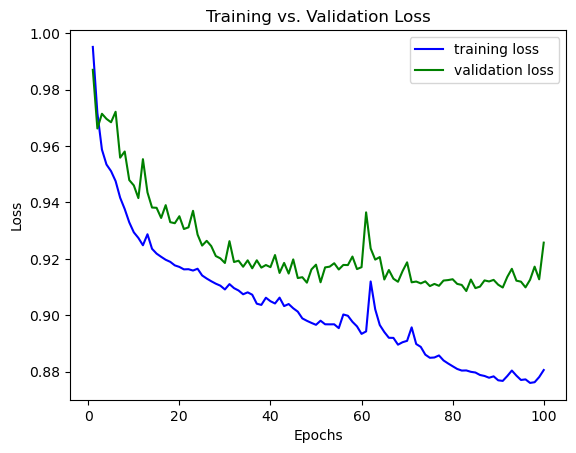

In [63]:
history_a = model_history

history_a.history #Gives us the results for each epoch

loss = history_a.history['loss'] #Create an array saving the loss values from the model

val_loss = history_a.history['val_loss'] #validation loss

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label = "training loss", color = "blue")
plt.plot(epochs, val_loss, 'y', label = "validation loss", color = "green")
plt.title("Training vs. Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


We want to go from high (1) to low (0) in loss. Here, we see them start to diverge as time goes on, so tweaking may be needed to improve the model accuracy.

C:\Users\Chance\AppData\Local\Temp\ipykernel_6224\3391955575.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, jaccard_coef, 'y', label = "Training IoU", color = "blue")
C:\Users\Chance\AppData\Local\Temp\ipykernel_6224\3391955575.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_jaccard_coef, 'y', label = "Validation IoU", color = "green")


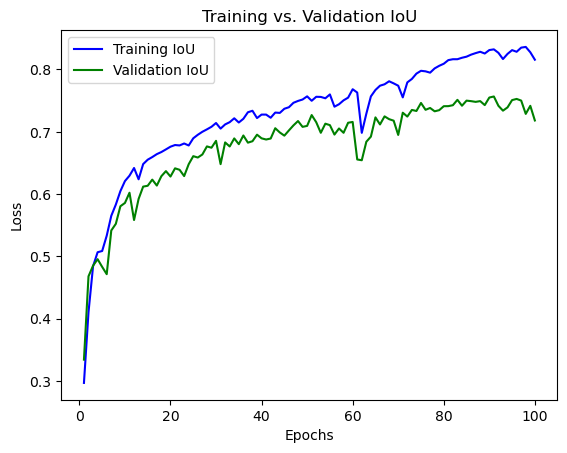

In [65]:
#Get the Jaccard Coeff values and plot
jaccard_coef = history_a.history['jaccard_coef'] #Create an array saving the loss values from the model

val_jaccard_coef = history_a.history['val_jaccard_coef'] #validation loss

epochs = range(1, len(loss) + 1)
plt.plot(epochs, jaccard_coef, 'y', label = "Training IoU", color = "blue")
plt.plot(epochs, val_jaccard_coef, 'y', label = "Validation IoU", color = "green")
plt.title("Training vs. Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Remember, the goal is to reach IoU = 1 since that represents a complete overlap in the training and test sets

In [66]:
model_history.params


{'verbose': 1, 'epochs': 100, 'steps': 51}

### Perform predictions
Now we can generate prediction for the full test data or single test image

In [68]:
y_pred = model.predict(x_test)

5/5 [==============================] - 6s 1s/step


In [71]:
#Length of test set to ensure it matches number of images (142) in test set
len(y_pred)

142

In [77]:
y_pred_argmax = np.argmax(y_pred, axis = 3)
len(y_pred_argmax)

142

In [79]:
y_test_argmax = np.argmax(y_test, axis = 3)
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

Compare the two to see how the test lines up with actual predicted values.

In [97]:
test_image_number = 10
test_image = x_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis = 3)
#slice predicted image
predicted_image = predicted_image[0,:,:]


1/1 [==============================] - 0s 80ms/step


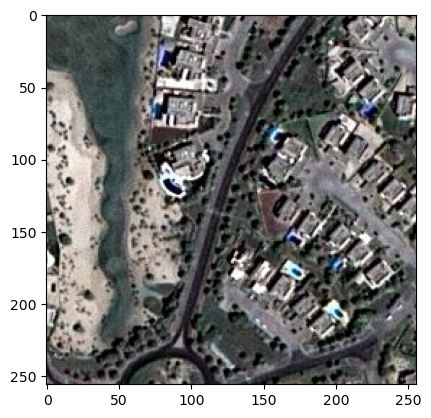

In [98]:
#Actual image
plt.imshow(test_image)

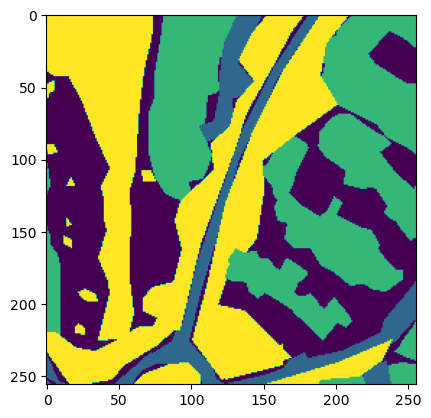

In [99]:
#From mask
plt.imshow(ground_truth_image)


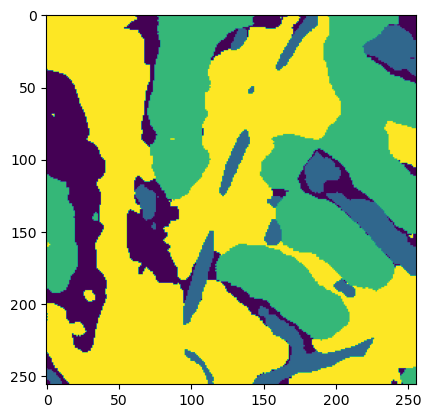

In [100]:
#Model prediction
plt.imshow(predicted_image)

Ok, so it's getting there, but still not super great.

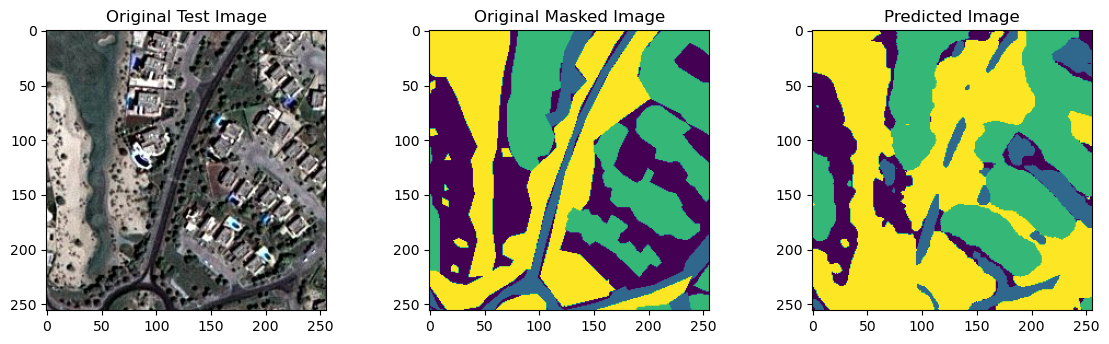

In [104]:
#Put all the images in a single output chunk
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.imshow(test_image)
plt.title("Original Test Image")

plt.subplot(232)
plt.title("Original Masked Image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

Now let's compare prediction results for random images rather than just the first image

In [120]:

test_image_number = random.randint(0,len(x_test))
test_image = x_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis = 3)
#slice predicted image
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 88ms/step


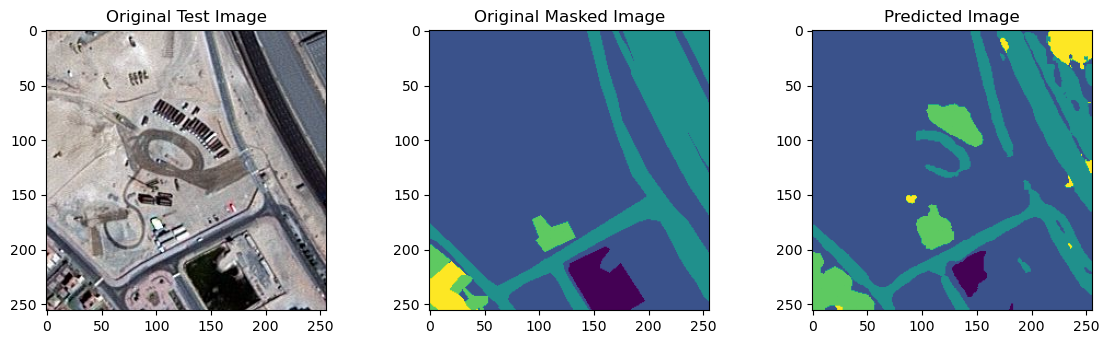

In [121]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.imshow(test_image)
plt.title("Original Test Image")

plt.subplot(232)
plt.title("Original Masked Image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

### Save model to disk so you don't need to run it for 3-4 hours each time!
Ideally you would save your optimized model, but I'm not bothering with this at the moment.

In [117]:
model.save("satellite_segmentation_full_model.h5") #Warning that .h5 is legacy file, recommends saving as kera

model.save("satellite_segmentation_full_model.keras") #Save as Keras file just in case it's better for the future

c:\Users\Chance\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model plot with Keras Tools 

In [126]:
# from keras.utils import plot_model


In [137]:
plot_model(model, to_file="satellite_model_plot.png", show_shapes = True, show_layer_names = True) #need to restart kernel to test this, and I don't want to spend 4hrs waiting right now...

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
